# Machine Learning HW5
##### 0756021 張逸群

In [1]:
import numpy as np
import pandas as pd
import itertools
import numba
import multiprocessing as mp
from functools import partial
from contextlib import redirect_stdout
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

### import libsvm

Importing `LibSVM` is rather simple. One can easily download and compile the source code from the official website, and it should be ready to operate.

In [2]:
import sys

sys.path.append('./libsvm-3.23/python')
import svmutil
import svm

## I. SVM on MNIST dataset

### Load Data

Here I choose to use `pandas.read_csv` to read the .csv file as arrays and, afterward, print out the size of each array to confirm the correctness.

In [3]:
X_train = pd.read_csv('./X_train.csv', header=None).values
y_train = pd.read_csv('./Y_train.csv', header=None).values.reshape(-1)

X_test = pd.read_csv('./X_test.csv', header=None).values
y_test = pd.read_csv('./Y_test.csv', header=None).values.reshape(-1)

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 784), (5000,), (2500, 784), (2500,))

### 1. Search for the best build-in hyperparameters

For this step, the grid parameter search algorithm was constructed.  
Since there are three types of kernels to search, the search range will be adjusted accordingly.   

1. Linear Kernel
    * -t 0
        * `u' * v`
    * cost range: [1, 5, 10]
      
2. Polynomial Kernel
    * -t 1
        * `( gamma * u' * v + coef0 )^degree`
    * cost range: [1, 5, 10]
    * degree range: [1, 3, 5]
    * coef0 range: [0, 5, 10]
    * gamma range: [1/784, 5/784, 10/784]
    
3. RBF Kernel
    * -t 2
        * `exp( -gamma * |u-v|^2)`
    * cost range: [1, 5, 10]
    * gamma range: [1/784, 5/784, 10/784]

A dictionary will be constructed for each search range which will have keys for options according to command-line.  
And then it'll be flattened to a string in order to be passed to the `svmutil.svmtrain` function.  
Furthermore, to speed up the process, the `multiprocessing` package is used to utilize the multi-core CPU potential.

For each parameter, `-v 3` flag is set to tell `LibSVM` to perform **3-fold cross-validation** on training set so that the resulting performance would be more trustworthy.  
After the search phase, the parameter resulting in the best performance would be chosen to train a final model on the whole training set.

In [5]:
def _quite_svm_train(y, X, ps):
    with redirect_stdout(open('/dev/null', 'w')):
        return svmutil.svm_train(y, X, ps)

def search_for_the_best(kernel, X, y):
    def product_dict(**kwargs):
        keys = kwargs.keys()
        vals = kwargs.values()
        for instance in itertools.product(*vals):
            yield dict(zip(keys, instance))
    
    def dict2str(d):
        s = ''
        for key, value in d.items():
            s = s + '{} {} '.format(key, value)
        return s
            
    search_range = {
        '-s': [0], # C-SVM
        '-v': [3], # corss validation
        '-q': [''],
        '-m': [2048], # cache-size: 2GB
        '-c': [1, 5, 10],
        '-t': [{'linear': 0, 'polynomial': 1, 'rbf': 2}[kernel]], # choose kernel
    }
    
    if kernel == 'polynomial':
        search_range['-d'] = [1, 3, 5] # degree
        search_range['-r'] = [0, 5, 10] # coef0
    
    if kernel == 'polynomial' or kernel == 'rbf':
        search_range['-g'] = [1./X.shape[1], 5./X.shape[1], 10./X.shape[1]] # gamma
    
    parameter_dicts = list(product_dict(**search_range))
    parameter_strings = list(map(dict2str, parameter_dicts))
    with mp.Pool(processes=16) as workers:
        partial_svm_train = partial(_quite_svm_train, y, X)
        results = [workers.apply_async(partial_svm_train, (ps, )) for ps in parameter_strings]
        results = [r.get() for r in tqdm(results)]
        
    # retrain with the whole X and y
    with redirect_stdout(open('/dev/null', 'w')):
        best_parameter = parameter_dicts[np.argmax(results)]
        best_model = svmutil.svm_train(y, X, dict2str(best_parameter).replace('-v 3', ' '))
        
    return best_model, best_parameter

In [6]:
linear_clf, linear_param = search_for_the_best('linear', X=X_train, y=y_train)
linear_labels, linear_acc, linear_vals = svmutil.svm_predict(y_test, X_test, linear_clf)

poly_clf, poly_param = search_for_the_best('polynomial', X=X_train, y=y_train)
poly_labels, poly_acc, poly_vals = svmutil.svm_predict(y_test, X_test, poly_clf)

rbf_clf, rbf_param = search_for_the_best('rbf', X=X_train, y=y_train)
rbf_labels, rbf_acc, rbf_vals = svmutil.svm_predict(y_test, X_test, rbf_clf)


Accuracy = 95.08% (2377/2500) (classification)



Accuracy = 97.48% (2437/2500) (classification)



Accuracy = 98.28% (2457/2500) (classification)


In [7]:
linear_param, poly_param, rbf_param

({'-s': 0, '-v': 3, '-q': '', '-m': 2048, '-c': 1, '-t': 0},
 {'-s': 0,
  '-v': 3,
  '-q': '',
  '-m': 2048,
  '-c': 10,
  '-t': 1,
  '-d': 5,
  '-r': 5,
  '-g': 0.012755102040816327},
 {'-s': 0,
  '-v': 3,
  '-q': '',
  '-m': 2048,
  '-c': 5,
  '-t': 2,
  '-g': 0.012755102040816327})

### Result
As stated above, the RBF kernel outperforms the other two kernels by 1 percent in the search range assigned.  
The following table shows the performance and the best parameter of each kernel:  

|   Kernel   | Accuracy on testing set (%) |                  Parameters                  | Rank on testing accuracy |
|:----------:|:---------------------------:|:--------------------------------------------:|:------------------------:|
|   Linear   |            95.08            |                     C: 1                     |             3            |
| Polynomial |            97.28            | C: 10, degree: 5, coef0: 10, gamma: 0.01275  |             2            |
|     RBF    |            98.28            |             C: 5, gamma: 0.01275             |             1            |

## 2. Linear Kernel + RBF Kernel

In order to use a user-defined kernel in `svmutil.svm_train`, the kernel value must be computed beforehand.  
The kernel function is defined as follows: 

* linear_rbf_K( x1, x2 ) = linear_K( x1, x2 ) + alpha * RBF_K( x1, x2 ) = x1.T @ x2 + alpha * exp( -gamma * || x1 - x2 ||^2 )  
    where alpha is to regulate the numerical values of the two combined kernel functions.

The shape of the pre-computed kernel would be (n_sample, n_sample+1) as each value `K[i, j+1]` represents the kernel distance between i-th and j-th sample and `K[i, 0]` represents the index of i-th sample.  
Before computing the full kernel defined above, linear kernel and RBF kernel are calculated and stored separately for further parameter searching. 

In [8]:
@numba.jit(nopython=True)
def _linear_kernel_base(x1, x2):
    return x1.T @ x2

@numba.jit(nopython=True)
def _rbf_kernel_base(x1, x2):
    return (x1 - x2).T @ (x1 - x2)

@numba.jit(parallel=True, nopython=True)
def kernel_base(X1, X2, kernel_function):
    K = np.zeros((X1.shape[0], X2.shape[0]))
    
    if X1.shape[0] == X2.shape[0] and np.equal(X1, X2).all():
        for i in numba.prange(X1.shape[0]):
            for j in numba.prange(i, X2.shape[0]):
                K[i, j] = kernel_function(X1[i], X2[j])
                K[j, i] = K[i, j]
    else:
        for i in numba.prange(X1.shape[0]):
            for j in numba.prange(X2.shape[0]):
                K[i, j] = kernel_function(X1[i], X2[j])
    
    return K
    
@numba.jit(parallel=True, nopython=True)
def combine_kernel(lk, rbfk, alpha, gamma):
    K = np.zeros((lk.shape[0], lk.shape[1] + 1))
    
    K[:, 1:] = lk + alpha * np.exp(-gamma * rbfk)
    K[:, 0] = np.arange(1, K.shape[0]+1, 1)
    return K
    
@numba.jit(parallel=True, nopython=True)
def linear_rbf_kernel(X1, X2, alpha, gamma):
    lr_base = kernel_base(X1, X2, _linear_kernel_base)
    rbf_base = kernel_base(X1, X2, _rbf_kernel_base)
    return combine_kernel(lr_base, rbf_base, alpha, gamma)

#### Grid Parameter Search

The procedure of the grid parameter search is pretty much the same as the last part,  
except that the linear and RBF kernel is pre-calculated and is combined with different alpha and gamma values when searching.  
The `multiprocessing` package and 3-fold cross-validation are still used to optimize the time consumption and smooth the performance.

* Search Range:
    * alpha: [100, 150, 300]
    * gamma: [5/784, 10/784, 20/784]
    
Finally, the model, which is retrained on the whole training set, with the best parameter is returned.

In [9]:
def _mp_combine_kernel_svm_training(y, lr_base, rbf_base, alpha, gamma, cv):
    with redirect_stdout(open('/dev/null', 'w')):
        X_transformed = combine_kernel(lr_base, rbf_base, alpha, gamma)
        return svmutil.svm_train(svm.svm_problem(y, X_transformed, isKernel=True), '-s 0 -t 4 -m 2048 -q -v {:d}'.format(cv))

def parameter_search_linear_rbf(X, y, alpha_range=None, gamma_range=None, cv=3):
    if alpha_range is None:
        alpha_range = [100, 150, 300]
    if gamma_range is None:
        gamma_range = [5/X.shape[1], 10/X.shape[1], 20/X.shape[1]]
    
    results = dict()
    lr_base = kernel_base(X, X, _linear_kernel_base)
    rbf_base = kernel_base(X, X, _rbf_kernel_base)
    
    with mp.Pool(processes=16) as workers:
        for alpha in alpha_range:
            for gamma in gamma_range:
                results[(alpha, gamma)] = workers.apply_async(_mp_combine_kernel_svm_training,
                                                              args=(y, lr_base, rbf_base, alpha, gamma, cv))
        
        with tqdm(total = len(alpha_range) * len(gamma_range)) as pbar:
            for alpha in alpha_range:
                for gamma in gamma_range:
                    results[(alpha, gamma)] = results[(alpha, gamma)].get()
                    pbar.update()
                    
    alpha, gamma = max(results, key=results.get)
    X_transformed = combine_kernel(lr_base, rbf_base, alpha, gamma)
    model = svmutil.svm_train(svm.svm_problem(y, X_transformed, isKernel=True), '-s 0 -t 4 -m 2048 -q')
    
    return model, (alpha, gamma)

In [10]:
model, parm = parameter_search_linear_rbf(X_train, y_train, cv=3)

In [11]:
X_test_transformed = linear_rbf_kernel(X_test, X_train, *parm)
linear_rbf_labels, linear_rbf_acc, linear_rbf_vals = svmutil.svm_predict(y_test, X_test_transformed, model)

Accuracy = 98.32% (2458/2500) (classification)


In [12]:
parm

(300, 0.025510204081632654)

#### Result

With the searched parameter - `(alpha: 300, gamma: 0.025551)`, this kernel is able to outperform all the other three kernel functions.  
The following table shows the performance and the best parameter of each kernel:

|    Kernel    | Accuracy on testing set (%) |                  Parameters                  | Rank on testing accuracy |
|:------------:|:---------------------------:|:--------------------------------------------:|:------------------------:|
|    Linear    |            95.08            |                     C: 1                     |             4            |
|  Polynomial  |            97.28            | C: 10, degree: 5, coef0: 10, gamma: 0.01275  |             3            |
|      RBF     |            98.28            |             C: 5, gamma: 0.01275             |             2            |
| Linear + RBF |            98.32            |        C: 1, alpha: 300, gamma: 0.02551      |             1            |

# II. Find out support vectors

### Load Data

In [13]:
X, y = pd.read_csv('./Plot_X.csv', header=None).values, pd.read_csv('./Plot_Y.csv', header=None).values.reshape(-1)

In [14]:
X.shape, y.shape

((3000, 2), (3000,))

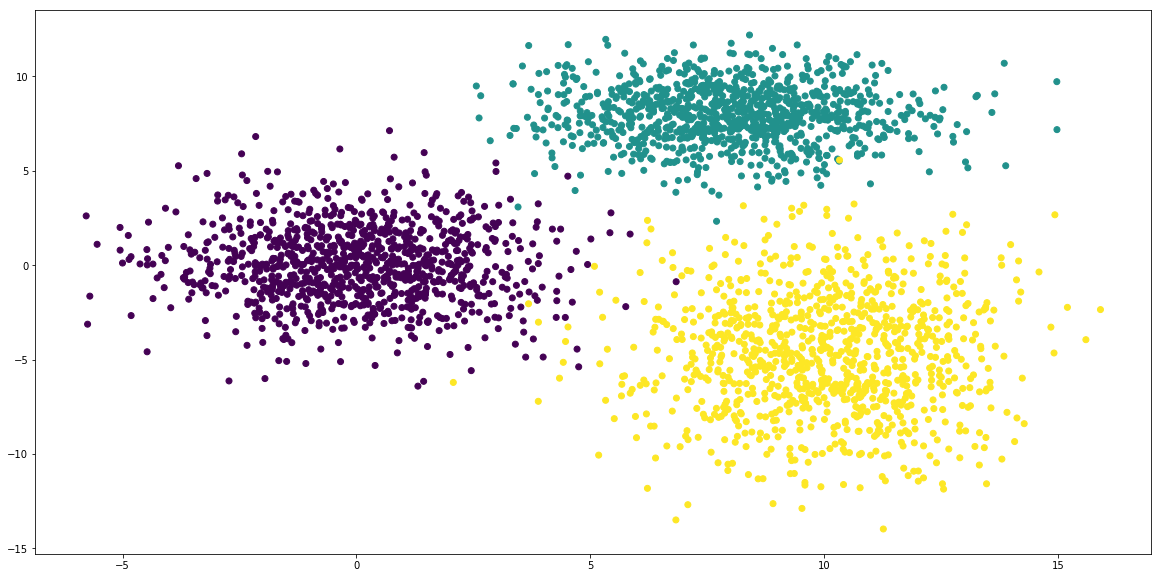

In [15]:
plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], c=y)

### Train 4 models with different kernel functions

Four models are constructed using the functions defined at I.1 & I.2 in this step for further observation.  
Linear kernel and polynomial kernel have slightly higher accuracy, however, since it's tested on the same set of data, this result might not mean much.

In [16]:
linear_clf, linear_param = search_for_the_best('linear', X=X, y=y)
linear_labels, linear_acc, linear_vals = svmutil.svm_predict(y, X, linear_clf)

poly_clf, poly_param = search_for_the_best('polynomial', X=X, y=y)
poly_labels, poly_acc, poly_vals = svmutil.svm_predict(y, X, poly_clf)

rbf_clf, rbf_param = search_for_the_best('rbf', X=X, y=y)
rbf_labels, rbf_acc, rbf_vals = svmutil.svm_predict(y, X, rbf_clf)

linear_rbf_clf, linear_rbf_parm = parameter_search_linear_rbf(X, y, cv=3)
X_transformed = linear_rbf_kernel(X, X, *parm)
linear_rbf_labels, linear_rbf_acc, linear_rbf_vals = svmutil.svm_predict(y, X_transformed, linear_rbf_clf)


Accuracy = 99.5667% (2987/3000) (classification)



Accuracy = 99.5667% (2987/3000) (classification)



Accuracy = 99.4667% (2984/3000) (classification)



Accuracy = 99.3333% (2980/3000) (classification)


### Plot Results

For visualization, support vectors' indices are extracted from models by `get_sv_indices`.  
Note that the indices are subtracted by one due to they are originally in the range [1, number_training_data].

In [17]:
def plot_result(title, model, labels, X, y):
    support_indices = np.array(model.get_sv_indices()) - 1
    svs = X[support_indices]
    
    plt.figure(figsize=(20, 10))
    plt.scatter(svs[:, 0], svs[:, 1], c='r', marker='^', label='support vectors')
    plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.3, label='data points')
    plt.title(title)
    plt.legend()
    plt.show()

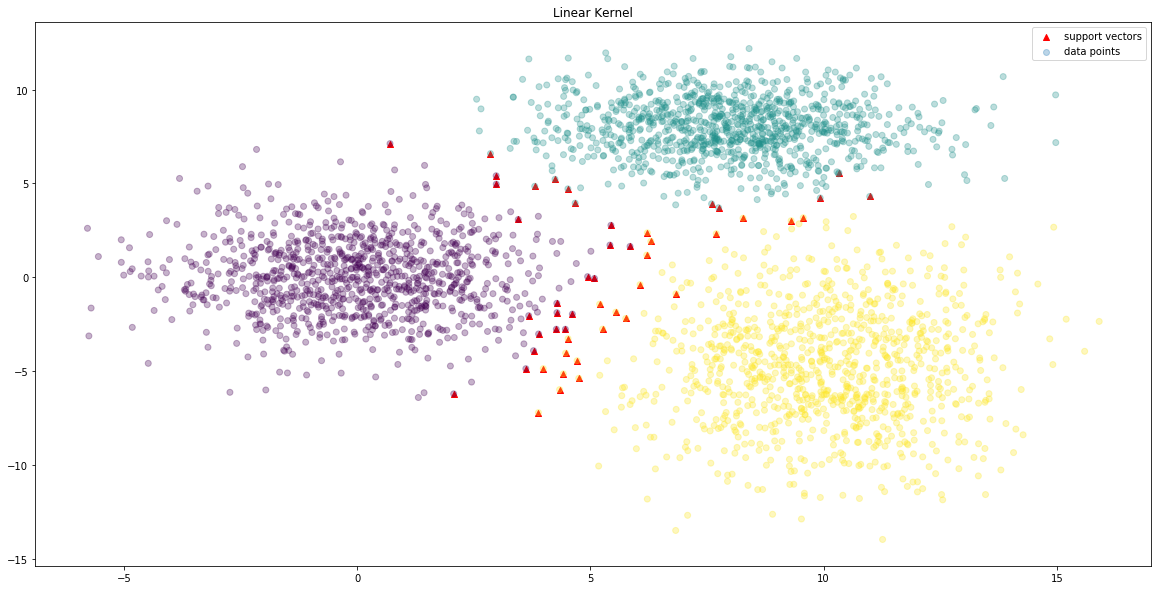

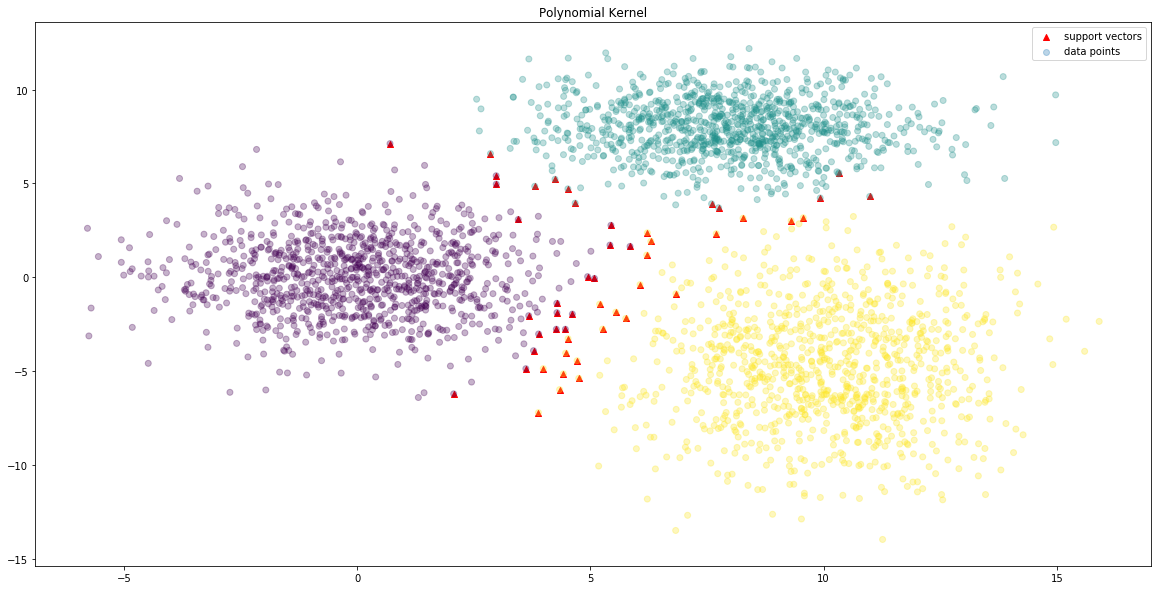

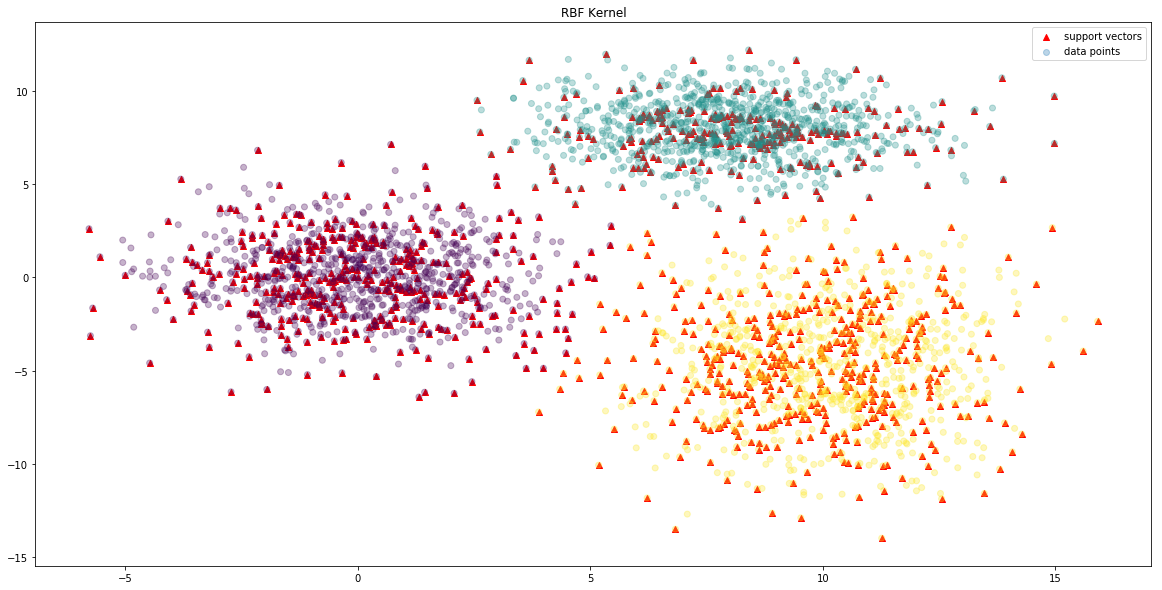

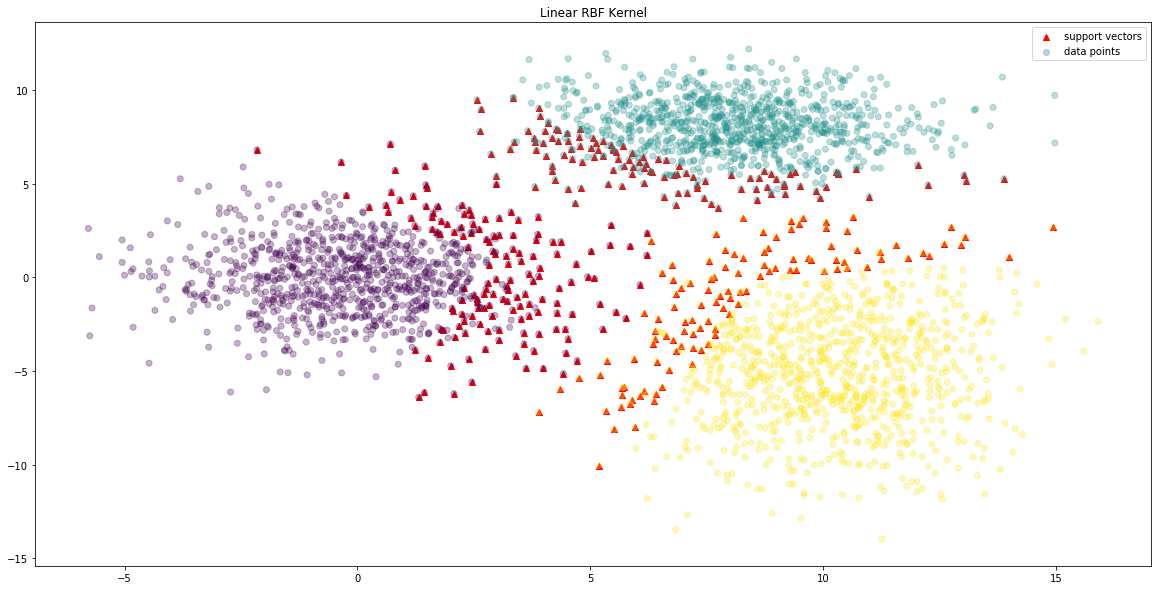

In [18]:
plot_result('Linear Kernel', linear_clf, linear_labels, X, y)
plot_result('Polynomial Kernel', poly_clf, poly_labels, X, y)
plot_result('RBF Kernel', rbf_clf, rbf_labels, X, y)
plot_result('Linear RBF Kernel', linear_rbf_clf, linear_rbf_labels, X, y)